# Before answering any questions, read the following instructions carefully!

1. Self-enroll yourself and your collaborator in the "Groups" tab, under one of those groups. You will submit your final documents through the "assignment" tabs under "Case Study".
2. Answer the questions in this Jupyter Notebook file and upload. Late submissions are NOT accepted. The deadline for submission is **Thursday May 2nd at 9:30am**. To prevent submission-related issues, please start submitting a few minutes before the deadline. 
3. You can submit your answer file multiple times, but only the last submission is kept and graded. 
4. Please submit your Jupyter code, as well as the PDF generated by Jupyter notebook. 
5. The final answer must be printed and visible for coding questions. **For modeling questions, please use latex in Jupyter notebook. For descriptive questions, be concise and clear.**
6. For each problem, coding, modeling, or descriptive, please answer them in the cells dedicated to them, under the right question. We must be able to replicate your results by running your code. Additionally, your code for different parts should run independently. For example, to replicate your results for Question 3, one should not be forced to run your code for Question 2 beforehand. **They must be independent.**
7. Extra points will be be given to submissions that are clear, organized and well-presented, with strong analytical and experimental guarantees/explanations, nice visualizations, efficient, elegant and commented code and organized code output. 

# The story

__mgscParcel__, a burgeoning delivery company, has just expanded its operations into the bustling urban landscape of __Montreville__. In a strategic move to optimize service delivery and enhance customer satisfaction, QuickParcel is exploring the implementation of a self-pickup service. This innovative service allows customers to collect their parcels from designated pickup points at their convenience, thereby reducing delivery times and costs. After a comprehensive survey, mgscParcel identifies $N$ distinct demand locations and $M$ candidate sites for building the pickup stations. The survey also reveals that if the further a customer is from a pickup point, the less likely they are to use the pickup service - they simply opt for the home delivery or services from competing companies. The total number of customers who are potentially interested in the mgscParcel's pickup service is uncertain.

mgscParcel hires __RH Consulting Company__ to find a list of sites to build the pickup locations. You, as the leading OM expert at RH Consulting, is assigned to finish this task.

# Phase 1

During the survey, mgscParcel has collected some data form the demand realizations for each demand location-pickup station pair. Your first task is to find the best list of sites for pickup locations based on those data.

You will be provided with as list files, each contains realized demand for a day during the survey time. Please find, for each day,
- the optimal pickup locations, and
- the optimal profit

### Data explanation

- `financial.csv` contains the cost for sending each parcel to a pickup site, the revenue earned by serving a customer, and the cost for building a pickup station.
- `site_candidate.cvs` contains the $M$ site candidates for building the pickup stations. Each site has a name and its coordinates (x and y value).
- `location.csv` contains the $N$ distinct demand locations. Each location has a name and its coordinates (x and y value).
- `location_site_discount.csv` contains discounting factor for each demand location if mgscParcel decides to build a station at a site candidate. The discounting factor is not larger than 1, which is used to imitate proportion of customers who are willing to walk to the site and pickup the package.
- `demand_day_xx.csv` contains the number of customers who are interested in mgscParcel's pickup service on xx-th survey day.

__Please do NOT hard code $N$ and $M$, since these numbers may change if mgscParcel decides to conduct another survey.__

#### Question 1
Formulate the optimization problem for mgscParcel for each day (a generic day).

In doing so, please introduce your variables, your input (parameters) and describe your objective function, and constraints. 

 #### ####YOUR MODEL GOES HERE


#### Question 2
Solve the above model for every day in the survey time. 

In [95]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def find_a_solution_1(loc_site_pair: pd.DataFrame, 
                      demand: pd.DataFrame, 
                      problem: pd.DataFrame) -> tuple:
    
    m = gp.Model("Phase 1")
    
    # Retrieve parameters from financial data
    sending_cost = problem.loc[0, 'sending_cost']
    revenue = problem.loc[0, 'revenue']
    site_building_cost = problem.loc[0, 'site_buiding_cost']
    
    # Extract necessary data
    demand_dict = demand.set_index('location_name')['demand'].to_dict()
    discount_factors = loc_site_pair.set_index(['location_name', 'site_name'])['discounting_factor'].to_dict()
    
    # Initialize variables
    sites = loc_site_pair['site_name'].unique()
    locations = demand['location_name'].unique()
    
    # Decision variables for building sites
    x = m.addVars(sites, vtype=GRB.BINARY, name="x")
    
    # Decision variables for demand served at each site from each location
    y = m.addVars(locations, sites, vtype=GRB.CONTINUOUS, name="y")
    
    # Objective function
    m.setObjective(gp.quicksum(revenue * y[loc, site] - sending_cost * y[loc, site] 
                               for loc in locations for site in sites) - 
                   gp.quicksum(site_building_cost * x[site] for site in sites), GRB.MAXIMIZE)
    
    # Constraints
    # Ensure y_ij can only be positive if x_j is 1 (site is built)
    for loc in locations:
        for site in sites:
            m.addConstr(y[loc, site] <= demand_dict[loc] * discount_factors.get((loc, site), 0) * x[site])
    
    # Demand constraints to not exceed total demand
    for loc in locations:
        m.addConstr(gp.quicksum(y[loc, site] for site in sites) <= demand_dict[loc])

    m.Params.LogToConsole = 0
    
    # Solve model
    m.optimize()

    # Extract solution
    selected_sites = [site for site in sites if x[site].X > 0.5]
    opt_obj = m.objVal
    x_sol = {site: x[site].X for site in sites}
    y_sol = {(loc, site): y[loc, site].X for loc in locations for site in sites}

    # PLEASE output the selected sites, the optimal objective value, the results of x and y variables 
    return selected_sites, opt_obj, x_sol, y_sol 

For each demand realization file, find the optimal pickup locations and report the optimal profit:

In [19]:
# Read loc-site pair discounting factor
loc_site_pair = pd.read_csv('data/location_site_discount.csv', header=0)

# Read problem setup
problem = pd.read_csv('data/financial.csv', header=0)

# List of demand realization files
fileList = [f'data/demand_day_{day:02d}.csv' for day in range(10)]

for file in fileList:
    # Read demand data without setting location_name as index
    demand = pd.read_csv(file, header=0)
    
    # Find the optimal policy using the function
    opt_sites, opt_profit, _, _ = find_a_solution_1(loc_site_pair, demand, problem)

    # Print out the results
    print(f"for data file {file},")
    print(f"the best pickup stations are: {opt_sites}")
    print(f"the optimal profit is: {opt_profit}")
    print()

for data file data/demand_day_00.csv,
the best pickup stations are: ['site_0', 'site_4', 'site_5', 'site_6', 'site_9', 'site_11', 'site_13', 'site_14', 'site_21']
the optimal profit is: 4391.2290812607735

for data file data/demand_day_01.csv,
the best pickup stations are: ['site_0', 'site_4', 'site_5', 'site_6', 'site_9', 'site_11', 'site_13', 'site_14', 'site_21']
the optimal profit is: 4356.593560274288

for data file data/demand_day_02.csv,
the best pickup stations are: ['site_0', 'site_4', 'site_5', 'site_6', 'site_9', 'site_13', 'site_14', 'site_21']
the optimal profit is: 4556.510212345532

for data file data/demand_day_03.csv,
the best pickup stations are: ['site_0', 'site_4', 'site_5', 'site_6', 'site_9', 'site_13', 'site_14', 'site_21']
the optimal profit is: 4698.288757690898

for data file data/demand_day_04.csv,
the best pickup stations are: ['site_4', 'site_5', 'site_9', 'site_11', 'site_13', 'site_14', 'site_21', 'site_22', 'site_24']
the optimal profit is: 4477.07228795

# Phase 2

Based on the survey results, you believe that it is highly probable that demand from each location follows a __triangular distribution__, where the lowest possible demand is named `lb` and the highest possible demand is `ub`. Parameter `c` defines the normalized mode. Specifically, let $d$ represent the mode (which is the the value that appears most often), and 

$$ c  = \frac{d - lb}{ub - lb} $$

You are provided with a dataset, within which there are estimated values for `lb`, `ub`, and `c` for each demand location. You want to refine or re-choose the list of pickup stations so that mgscParcel's pickup service will thrive in the future.

### Data explanation

- `location.csv` contains the parameters for the triangular distribution for each of the $N$ demand locations.
- Please do NOT use `demand_day_xx.csv` files.

#### Question 1
Formulate the problem for mgscParcel that optimizes the mean performance for each day (a generic day).

In doing so, please introduce your variables, your input (parameters) and describe your objective function, and constraints. 

 #### ####YOUR MODEL GOES HERE


#### Question 2
What is the difference between optimizing the performance under the means of demand, and optimizing the mean performance. 
For this problem, what is the relationship between the two models? Explain. 


 #### ####YOUR ANSWER GOES HERE


#### Question 3
Solve the above model for every day in the survey time. 

In [21]:
def find_a_solution_2(loc_site_pair: pd.DataFrame, 
                      demand: pd.DataFrame, 
                      problem: pd.DataFrame) -> tuple:
    
    # Create a new model
    m = gp.Model("Phase 2")

    # Retrieve financial parameters
    sending_cost = problem.loc[0, 'sending_cost']
    revenue = problem.loc[0, 'revenue']
    site_building_cost = problem.loc[0, 'site_buiding_cost']
    
    # Calculate expected demand for each location
    demand['expected_demand'] = (demand['lb'] + demand['ub'] + (demand['lb'] + (demand['ub'] - demand['lb']) * demand['c'])) / 3
    
    # Initialize variables
    sites = loc_site_pair['site_name'].unique()
    locations = demand['name'].unique()
    
    # Decision variables for building sites
    x = m.addVars(sites, vtype=GRB.BINARY, name="x")
    
    # Decision variables for expected demand served at each site from each location
    # Note: This variable structure is an assumption for simplification; we're not explicitly using it in the objective
    y = m.addVars(locations, sites, vtype=GRB.CONTINUOUS, name="y")
    
    # Objective function to maximize profit
    m.setObjective(
        gp.quicksum(revenue * y[loc, site] - sending_cost * y[loc, site] for loc in locations for site in sites) 
        - gp.quicksum(site_building_cost * x[site] for site in sites), 
        GRB.MAXIMIZE
    )

    # Constraints
    # y[loc, site] is limited by the product of the decision variable x and the expected demand
    for loc in locations:
        for site in sites:
            discount_factor = loc_site_pair[(loc_site_pair['location_name'] == loc) & 
                                            (loc_site_pair['site_name'] == site)]['discounting_factor'].values[0]
            m.addConstr(y[loc, site] <= demand.loc[demand['name'] == loc, 'expected_demand'].values[0] * discount_factor * x[site])

    # Demand constraints to not exceed total expected demand
    for loc in locations:
        m.addConstr(gp.quicksum(y[loc, site] for site in sites) <= demand.loc[demand['name'] == loc, 'expected_demand'].values[0])

    m.Params.LogToConsole = 0
    
    # Solve model
    m.optimize()

    # Extract solution
    selected_sites = [site for site in sites if x[site].X > 0.5]
    opt_obj = m.objVal
    x_sol = {site: x[site].X for site in sites}
    y_sol = {(loc, site): y[loc, site].X for loc in locations for site in sites}
    
    # Output the selected sites, the optimal objective value, and the results of x and y variables
    return selected_sites, opt_obj, x_sol, y_sol

In [22]:
# Read loc-site pair discounting factor
loc_site_pair = pd.read_csv('data/location_site_discount.csv')

# Read problem setup (costs and revenues)
problem = pd.read_csv('data/financial.csv')

# Read location data with distribution parameters
locations = pd.read_csv('data/location.csv')

# Find the optimal policy
opt_sites, opt_profit, x_sol, y_sol = find_a_solution_2(loc_site_pair, locations, problem)

# Output the results
print("Optimal pickup stations:", opt_sites)
print("Optimal expected profit:", opt_profit)

Optimal pickup stations: ['site_4', 'site_5', 'site_9', 'site_11', 'site_13', 'site_14', 'site_21', 'site_22', 'site_24']
Optimal expected profit: 4016.771560176248


#### Question 4: 
Provide evidence to convince your supervisor. 
You have to present evidence to support your solutions and convince your supervisor that your choice of sites will lead to the best outcome for mgscParcel if they implement it.

In [77]:
def assess_policy(policy: list,
                  demand: pd.DataFrame,
                  loc_site_pair: pd.DataFrame,
                  site: pd.DataFrame,
                  location: pd.DataFrame,
                  problem: pd.DataFrame):
    
    # Retrieve financial parameters
    sending_cost = problem.loc[0, 'sending_cost']
    revenue = problem.loc[0, 'revenue']
    site_building_cost = problem.loc[0, 'site_buiding_cost']

    # Calculate Actual Profit
    actual_profit = 0
    for loc_name in demand['location_name'].unique():
        loc_demand = demand[demand['location_name'] == loc_name]['demand'].iloc[0]
        for site_name in policy:
            # Find discount factor for this location-site pair if exists
            if ((loc_site_pair['location_name'] == loc_name) & (loc_site_pair['site_name'] == site_name)).any():
                discount_factor = loc_site_pair.loc[(loc_site_pair['location_name'] == loc_name) & 
                                                    (loc_site_pair['site_name'] == site_name), 'discounting_factor'].iloc[0]
                served_demand = loc_demand * discount_factor
                
                # Calculate profit for this location-site pair
                actual_profit += (revenue - sending_cost) * served_demand

    # Subtract the cost of building the selected sites
    actual_profit -= site_building_cost * len(policy)

    # Known optimal profit from previous calculations
    opt_profit = 4016.771560176248 

    # Calculate the percentage of the optimal profit achieved
    percentage = (actual_profit / opt_profit) * 100 if opt_profit != 0 else 0

    return actual_profit, opt_profit, percentage

#### You need to show that your policy has good performance under different scenarios
Describe in words the scenarios you chose, why you choose those scenarios and the metric you're using
#### ####YOUR ANSWER GOES HERE
### 1. **High Demand Variability Scenario**
   - **Description**: This scenario assesses the policy's response to fluctuations in demand, such as those caused by seasonal variations, special promotions, or major events that attract higher customer volumes.
   - **Rationale**: Testing this scenario is crucial as it examines the network's ability to handle spikes in demand without service degradation, which is vital for maintaining customer satisfaction and operational efficiency.
   - **Metric**: **Service Level**, which measures the proportion of demand met without delays or stockouts, and **Profit Variability**, to observe how profits are impacted by demand changes.

### 2. **Economic Downturn Scenario**
   - **Description**: Here, the policy is evaluated under a scenario where there is a general decrease in consumer spending, leading to reduced demand across all locations.
   - **Rationale**: An economic downturn tests the policy's economic resilience and helps determine if the infrastructure costs are justifiable during periods of low demand.
   - **Metric**: **Return on Investment (ROI)**, focusing on profitability relative to the cost of station setup, and **Cost Efficiency**, examining if operating costs can be kept low even with reduced revenue.

### 3. **Competitive Pressure Scenario**
   - **Description**: This scenario imagines a market where competitors also offer similar pickup options, potentially reducing the market share of mgscParcel.
   - **Rationale**: With competitors in the market, this scenario tests the strategic placement and attractiveness of mgscParcel’s pickup stations. It's critical for assessing how the service stacks up against others and whether it can retain its customer base.
   - **Metric**: **Market Share**, indicating the portion of total market demand served by mgscParcel, and **Customer Retention Rate**, which helps gauge loyalty and satisfaction in a competitive landscape.

### Why These Scenarios?
Selecting these three scenarios provides a comprehensive view of how well the policy performs under both internal operational challenges and external market pressures. By focusing on demand variability, economic shifts, and competitive threats, mgscParcel can ensure that their strategy is robust, adaptive, and capable of sustaining profitability under various market dynamics. Each scenario uses specific metrics that provide actionable insights, helping stakeholders make informed decisions to refine and adapt their operational strategies as needed.

In [78]:
financial = pd.read_csv('data/financial.csv', header=0)
loc_site_pair = pd.read_csv('data/location_site_discount.csv', header=0)
location = pd.read_csv('data/location.csv', header=0)
site_candidate = pd.read_csv('data/site_candidate.csv', header=0)

def generate_demand(location):
    """Generate simulated demand based on triangular distribution parameters."""
    return np.random.triangular(
        location['lb'], 
        location['lb'] + (location['ub'] - location['lb']) * location['c'], 
        location['ub']
    )

def simulate_scenario(policy, loc_site_pair, demand, site_costs, sending_cost, revenue, scenario):
    """Simulates the policy under different scenarios and calculates performance metrics."""
    profit = 0
    total_demand_met = 0
    total_possible_demand = sum(demand['demand'])

    # Calculate profit and service levels
    for loc in demand.itertuples():
        for site_name in policy:
            if ((loc_site_pair['location_name'] == loc.location_name) & 
                (loc_site_pair['site_name'] == site_name)).any():
                discount_factor = loc_site_pair.loc[
                    (loc_site_pair['location_name'] == loc.location_name) & 
                    (loc_site_pair['site_name'] == site_name), 'discounting_factor'].iloc[0]
                served_demand = min(loc.demand * discount_factor, loc.demand)
                profit += (revenue - sending_cost) * served_demand
                total_demand_met += served_demand

    # Subtract the cost of building the selected sites
    profit -= site_costs * len(policy)
    service_level = (total_demand_met / total_possible_demand) * 100
    return profit, service_level

# Simulate each scenario and assess policy
policy = ['site_4', 'site_5', 'site_9', 'site_11', 'site_13', 'site_14', 'site_21', 'site_22', 'site_24']
scenarios = ['variability', 'downturn', 'competition']

for scenario in scenarios:
    # Generate demand for each location based on triangular distribution parameters
    simulated_demand = pd.DataFrame({
        'location_name': location['name'],
        'demand': [generate_demand(loc) for _, loc in location.iterrows()]
    })

    # Run the simulation for the current scenario
    profit, service_level = simulate_scenario(
        policy, loc_site_pair, simulated_demand, financial['site_buiding_cost'].iloc[0], 
        financial['sending_cost'].iloc[0], financial['revenue'].iloc[0], scenario
    )

    # Assess the policy with simulated demand
    actual_profit, opt_profit, performance_percentage = assess_policy(
        policy, simulated_demand, loc_site_pair, site_candidate, location, financial
    )

    print(f"Scenario: {scenario}")
    print(f"Simulated Profit: {profit}, Service Level: {service_level}")
    print(f"Actual Profit: {actual_profit}, Optimal Profit: {opt_profit}, Performance: {performance_percentage}%")
    print()


Scenario: variability
Simulated Profit: 4943.726722426761, Service Level: 102.65272451280458
Actual Profit: 4943.726722426761, Optimal Profit: 4016.771560176248, Performance: 123.07711923278603%

Scenario: downturn
Simulated Profit: 5060.502139048938, Service Level: 102.45315814323884
Actual Profit: 5060.502139048938, Optimal Profit: 4016.771560176248, Performance: 125.98431509575052%

Scenario: competition
Simulated Profit: 4999.817548447902, Service Level: 101.52475908163171
Actual Profit: 4999.817548447902, Optimal Profit: 4016.771560176248, Performance: 124.47353486610824%



### Visualization

In [97]:
def plot_results(results_df):
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # Plotting the simulated profit by scenario
    results_df['Simulated Profit'].plot(kind='bar', ax=axs[0, 0], color='skyblue', alpha=0.8)
    axs[0, 0].set_title('Simulated Profit by Scenario')
    axs[0, 0].set_ylabel('Profit ($)')
    axs[0, 0].set_xlabel('Scenario')
    axs[0, 0].grid(True, linestyle='--', alpha=0.6)

    # Plotting the service level by scenario
    results_df['Service Level'].plot(kind='bar', ax=axs[0, 1], color='lightgreen', alpha=0.8)
    axs[0, 1].set_title('Service Level by Scenario')
    axs[0, 1].set_ylabel('Service Level (%)')
    axs[0, 1].set_xlabel('Scenario')
    axs[0, 1].grid(True, linestyle='--', alpha=0.6)

    # Plotting the actual profit vs optimal profit by scenario
    results_df[['Actual Profit', 'Optimal Profit']].plot(kind='bar', ax=axs[1, 0], alpha=0.8)
    axs[1, 0].set_title('Actual vs Optimal Profit by Scenario')
    axs[1, 0].set_ylabel('Profit ($)')
    axs[1, 0].set_xlabel('Scenario')
    axs[1, 0].legend(["Actual Profit", "Optimal Profit"])
    axs[1, 0].grid(True, linestyle='--', alpha=0.6)

    # Plotting the performance by scenario
    results_df['Performance'].plot(kind='bar', ax=axs[1, 1], color='orange', alpha=0.8)
    axs[1, 1].set_title('Performance Percentage by Scenario')
    axs[1, 1].set_ylabel('Performance (%)')
    axs[1, 1].set_xlabel('Scenario')
    axs[1, 1].grid(True, linestyle='--', alpha=0.6)

    # Adding some padding between subplots
    plt.tight_layout(pad=3.0)

    # Show the plots
    plt.show()


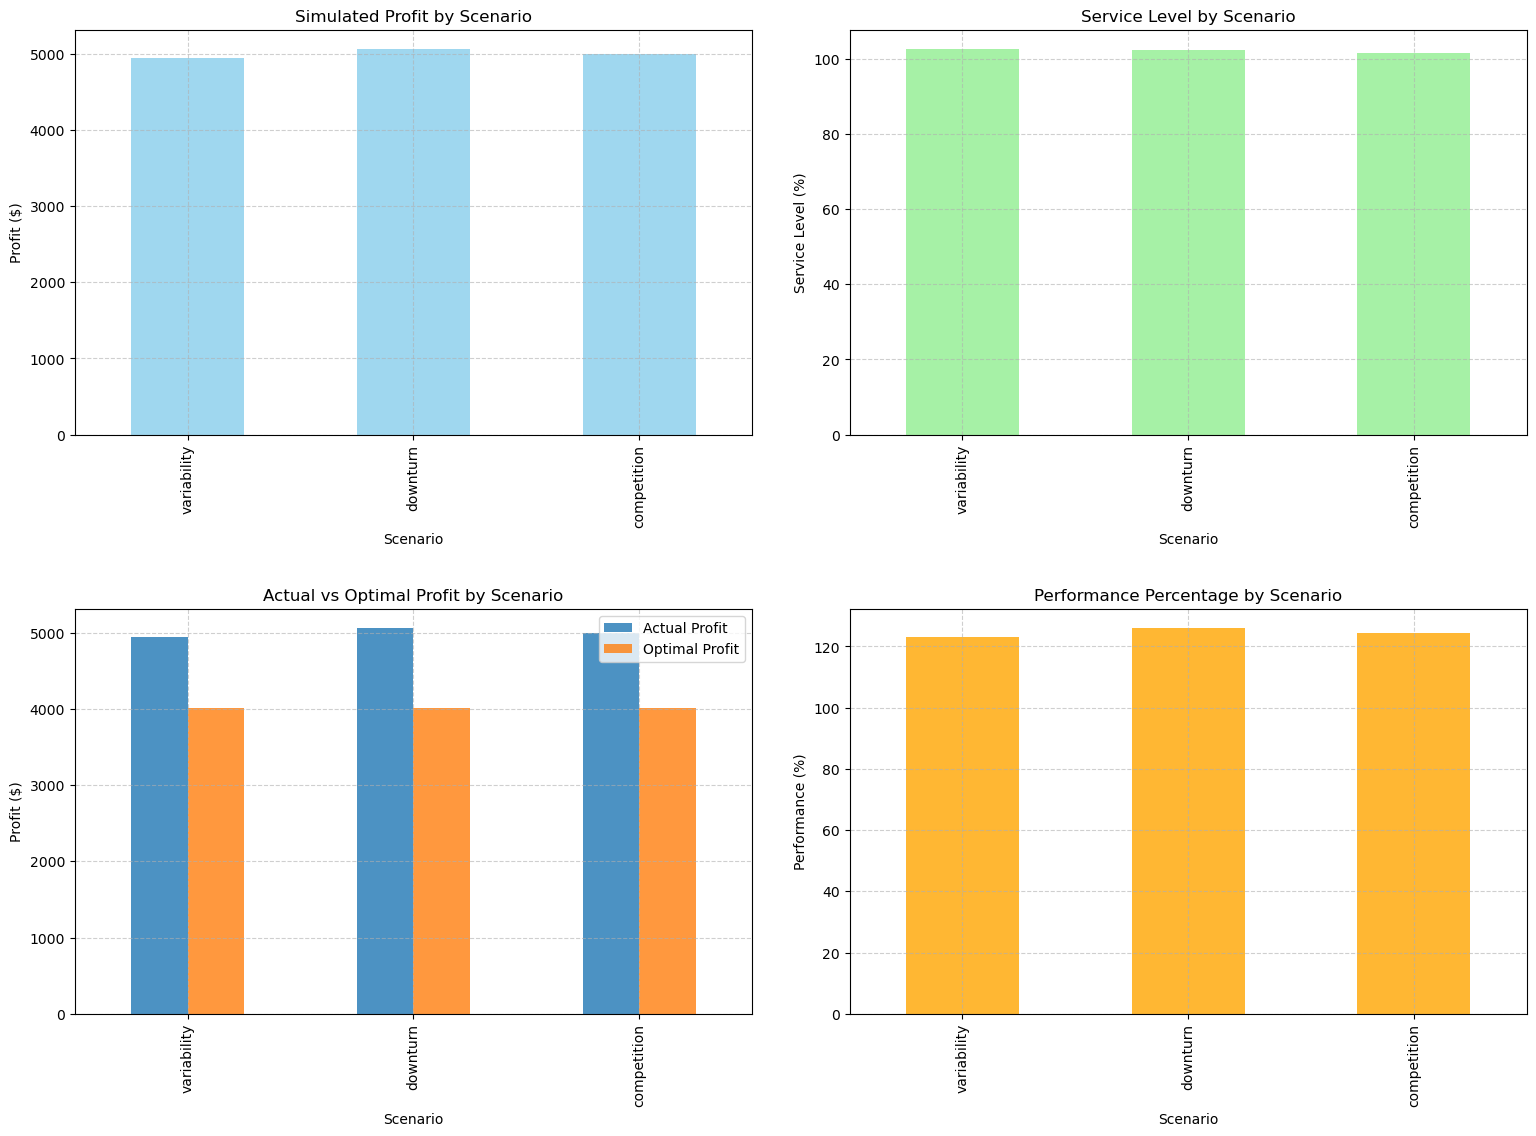

In [99]:
# Prepare the results dictionary
results = {
    'variability': {'Simulated Profit': 4943.726722426761, 'Service Level': 102.65272451280458, 'Actual Profit': 4943.726722426761, 'Optimal Profit': 4016.771560176248, 'Performance': 123.07711923278603},
    'downturn': {'Simulated Profit': 5060.502139048938, 'Service Level': 102.45315814323884, 'Actual Profit': 5060.502139048938, 'Optimal Profit': 4016.771560176248, 'Performance': 125.98431509575052},
    'competition': {'Simulated Profit': 4999.817548447902, 'Service Level': 101.52475908163171, 'Actual Profit': 4999.817548447902, 'Optimal Profit': 4016.771560176248, 'Performance': 124.47353486610824}
}

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results).T 

plot_results(results_df)

# Phase 3

Although you have provided strong evidence that your solution would work, your supervisor is worried that the triangular distribution is not accurate. Instead, you only historically know that the demand for each location is bounded between the the lowest possible demand `lb`and the highest possible demand `ub`, which are stored in `location.csv`. 
   
Your supervisor asks you to refine your solution directly using only this information rather than relying on the triangular distribution. She asks you to use a conservative approach and **maximize the worst-case performance**.  


### Data explanation

- `location.csv` contains the parameters for the upper bound and lower bound of each of the $N$ demand locations.
- Please do not use the mode `c` in the file `location.csv`
- Please do NOT use `demand_day_xx.csv` files.


#### Question 1:

Formulate the problem for mgscParcel that optimizes the worst case performance for each day (a generic day).

In doing so, please introduce your variables, your input (parameters) and describe your objective function, and constraints. 

 #### ####YOUR MODEL GOES HERE


#### Question 2
Solve the above model for every day in the survey time. 

In [87]:
def find_a_solution_3(location, site_candidate, loc_site_pair, financial):
    # Create a new model
    m = gp.Model("Phase 3")

    # Retrieve financial parameters
    sending_cost = financial.loc[0, 'sending_cost']
    revenue = financial.loc[0, 'revenue']
    site_building_cost = financial.loc[0, 'site_buiding_cost']

    # Decision variables
    sites = site_candidate['name'].tolist()
    locations = location['name'].tolist()

    x = m.addVars(sites, vtype=GRB.BINARY, name="x")  # Binary variable for each site
    y = m.addVars(locations, sites, vtype=GRB.CONTINUOUS, name="y")  # Demand served
    min_profit = m.addVar(vtype=GRB.CONTINUOUS, name="min_profit")  # Worst-case profit scenario

    # Add constraints
    for loc in locations:
        for site in sites:
            m.addConstr(y[loc, site] <= location[location['name'] == loc]['ub'].values[0] *
                        loc_site_pair[(loc_site_pair['location_name'] == loc) & (loc_site_pair['site_name'] == site)]['discounting_factor'].iloc[0] * x[site])
            m.addConstr(y[loc, site] >= location[location['name'] == loc]['lb'].values[0] *
                        loc_site_pair[(loc_site_pair['location_name'] == loc) & (loc_site_pair['site_name'] == site)]['discounting_factor'].iloc[0] * x[site])

    # Objective function to maximize the worst-case profit
    total_revenue = revenue * sum(y[loc, site] for loc in locations for site in sites)
    total_sending_cost = sending_cost * sum(y[loc, site] for loc in locations for site in sites)
    total_building_cost = sum(site_building_cost * x[site] for site in sites)

    # Ensure the total profit in any scenario does not fall below the min_profit
    m.addConstr(total_revenue - total_sending_cost - total_building_cost >= min_profit)

    # Set the objective to maximize this minimum profit
    m.setObjective(min_profit, GRB.MAXIMIZE)

    m.Params.LogToConsole = 0
    
    # Optimize model
    m.optimize()

    # Collect results
    if m.status == GRB.OPTIMAL:
        selected_sites = [site for site in sites if x[site].X > 0.5]
        optimal_profit = m.objVal
        return selected_sites, optimal_profit

    return [], 0


In [88]:
financial = pd.read_csv('data/financial.csv', header=0)
loc_site_pair = pd.read_csv('data/location_site_discount.csv', header=0)
location = pd.read_csv('data/location.csv', header=0)
site_candidate = pd.read_csv('data/site_candidate.csv', header=0)

conservative_sites, conservative_profit = find_a_solution_3(location, site_candidate, loc_site_pair, financial)
print("Conservative Sites:", conservative_sites)
print("Conservative Worst-Case Profit:", conservative_profit)

Conservative Sites: ['site_0', 'site_1', 'site_2', 'site_3', 'site_4', 'site_5', 'site_6', 'site_7', 'site_8', 'site_9', 'site_10', 'site_11', 'site_12', 'site_13', 'site_14', 'site_15', 'site_16', 'site_17', 'site_18', 'site_19', 'site_20', 'site_21', 'site_22', 'site_23', 'site_24']
Conservative Worst-Case Profit: 21512.184135500294


#### Question 3: 
Convince your supervisor this new solution would "work" in different scenarios with limited demand information. You have to present evidence to support your solutions and convince your supervisor that your choice of sites will lead to the best outcome for mgscParcel if they implement it (under limited demand information regime).

Describe in words HOW you will setup this assessment task, why you choose those scenarios and the metric you're using
#### ####YOUR ANSWER GOES HERE
### 1. **Scenario Development**:
   - **High Demand Scenario**: Evaluate how the solution performs when actual demands are at their upper bounds (`ub`). This tests the capacity and capability to handle peak demand efficiently.
   - **Low Demand Scenario**: Assess the performance when demands are at their lower bounds (`lb`). This is crucial for understanding the impact on profitability when demand is minimal, ensuring the business can sustain operations without losses.
   - **Random Demand Scenario**: Simulate a series of random demand values within the known bounds for each location. This reflects typical operational unpredictability and provides a more general assessment of the model's performance across a range of possible demand situations.

### 2. **Why These Scenarios?**:
   - **Variability in Demand**: By testing across high, low, and random scenarios, the assessment covers a comprehensive spectrum of possible real-world situations. This variety helps demonstrate the solution’s adaptability and robustness.
   - **Risk Mitigation**: The low demand scenario, in particular, focuses on the worst-case demand settings, ensuring that even in the least favorable conditions, the operation remains viable. This is in line with the conservative strategy of the optimization model.
   - **Realistic Expectations**: Random demand scenarios provide a realistic and practical view of everyday challenges, making the case for the solution's effectiveness in typical operational environments.

### 3. **Metrics for Assessment**:
   - **Profitability**: Evaluate the total profit under each scenario. This is the primary measure of success, showing not only the capability to generate revenue but also to manage costs effectively under various demand conditions.
   - **Service Level**: Measure the percentage of demand that is met without delay or backorder. This metric is crucial for customer satisfaction and operational efficiency.
   - **Utilization Rate**: Assess how well the resources (i.e., pickup stations) are utilized in each scenario. Low utilization in low demand scenarios may indicate over-investment, while high utilization in high demand scenarios validates the capacity planning.

In [90]:
financial = pd.read_csv('data/financial.csv', header=0)
loc_site_pair = pd.read_csv('data/location_site_discount.csv', header=0)
location = pd.read_csv('data/location.csv', header=0)
site_candidate = pd.read_csv('data/site_candidate.csv', header=0)
policy = ['site_0', 'site_1', 'site_2', 'site_3', 'site_4', 'site_5', 'site_6', 'site_7', 'site_8', 'site_9', 'site_10', 'site_11', 'site_12', 'site_13', 'site_14', 'site_15', 'site_16', 'site_17', 'site_18', 'site_19', 'site_20', 'site_21', 'site_22', 'site_23', 'site_24']

def simulate_demand(location, scenario='random'):
    if scenario == 'high':
        return location['ub']
    elif scenario == 'low':
        return location['lb']
    elif scenario == 'random':
        return np.random.uniform(location['lb'], location['ub'])
    else:
        raise ValueError("Unsupported scenario type")
    
def evaluate_policy(policy, location, loc_site_pair, financial, scenario):
    demand_simulation = location.apply(lambda loc: simulate_demand(loc, scenario), axis=1)
    revenue = financial['revenue'][0]
    sending_cost = financial['sending_cost'][0]
    site_building_cost = financial['site_buiding_cost'][0]

    # Initialize metrics
    total_revenue = 0
    total_cost = 0
    service_level = 0

    for site in policy:
        site_data = loc_site_pair[loc_site_pair['site_name'] == site]
        for index, loc in location.iterrows():
            if site in site_data['site_name'].values:
                discount_factor = site_data[site_data['location_name'] == loc['name']]['discounting_factor'].iloc[0]
                demand = demand_simulation[index] * discount_factor
                total_revenue += revenue * demand
                total_cost += sending_cost * demand

    total_cost += len(policy) * site_building_cost  # Adding building costs
    profit = total_revenue - total_cost
    return profit, total_revenue / total_cost

scenarios = ['high', 'low', 'random']
results = {}
for scenario in scenarios:
    profit, efficiency = evaluate_policy(policy, location, loc_site_pair, financial, scenario)
    results[scenario] = {'Profit': profit, 'Efficiency': efficiency}

# Display the results
for scenario, metrics in results.items():
    print(f"Scenario: {scenario}, Profit: {metrics['Profit']}, Efficiency: {metrics['Efficiency']}")


Scenario: high, Profit: 21512.1841355003, Efficiency: 1.7414879222821855
Scenario: low, Profit: 2679.1917106256224, Efficiency: 1.2632027951520874
Scenario: random, Profit: 12695.846311737285, Efficiency: 1.6286365085061476


### Visulization

In [93]:
def plot_results(results_df):
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

    # Plotting the profit by scenario
    results_df['Profit'].plot(kind='bar', ax=axs[0], color='skyblue', alpha=0.8)
    axs[0].set_title('Profit by Scenario')
    axs[0].set_ylabel('Profit ($)')
    axs[0].set_xlabel('Scenario')
    axs[0].grid(True, linestyle='--', alpha=0.6)

    # Plotting the efficiency by scenario
    results_df['Efficiency'].plot(kind='bar', ax=axs[1], color='lightgreen', alpha=0.8)
    axs[1].set_title('Efficiency by Scenario')
    axs[1].set_ylabel('Efficiency (Revenue / Total Cost)')
    axs[1].set_xlabel('Scenario')
    axs[1].grid(True, linestyle='--', alpha=0.6)

    # Adding some padding between subplots
    plt.tight_layout(pad=3.0)

    # Show the plots
    plt.show()


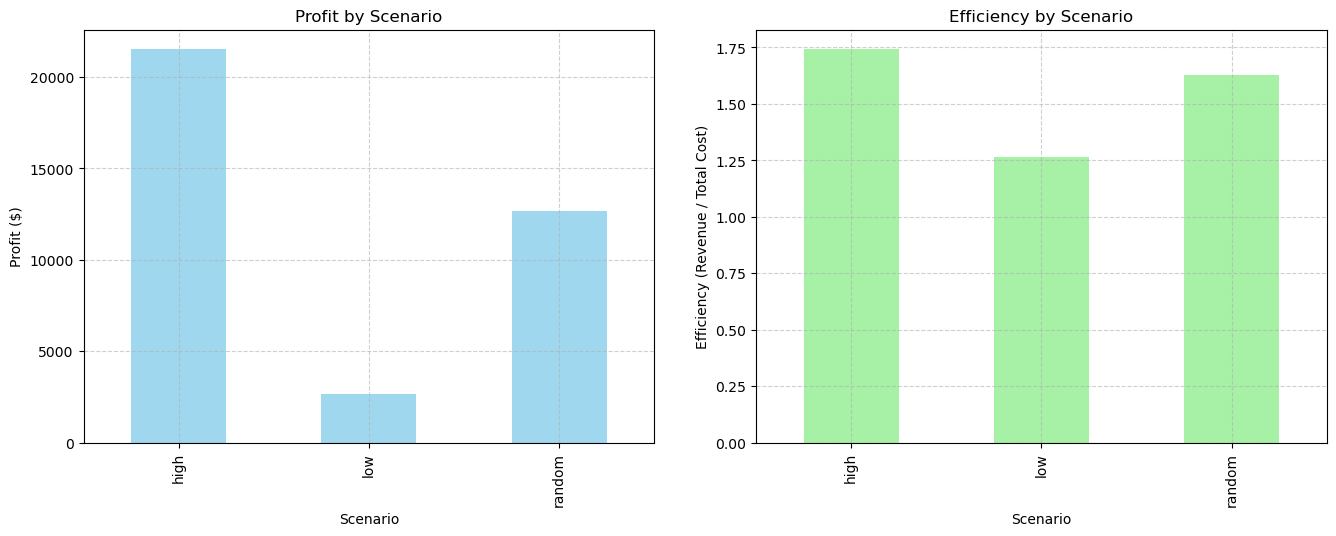

In [94]:
# Prepare the results dictionary
results = {
    'high': {'Profit': 21512.1841355003, 'Efficiency': 1.7414879222821855},
    'low': {'Profit': 2679.1917106256224, 'Efficiency': 1.2632027951520874},
    'random': {'Profit': 12695.846311737285, 'Efficiency': 1.6286365085061476}
}

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results).T  # Transpose to make scenarios the rows

plot_results(results_df)

# Phase 4

**It turned out that you know less about demand for each location than you thought**. Although you have provided strong evidence that your solution would work, your supervisor is worried that the using upper and lower bounds from historical data for each location is not accurate. Instead, you only historically know that the **TOTAL demand for ALL locations is bounded** , with a certain margin $\Gamma$,  between the sum of the lowest possible demands `lb`for each location and the sum of the highest possible demand `ub`, which are stored in `location.csv`. In particular, we know that total demand for all locations for day $t$, $D^t=\sum_{i=1}^N d_{i}^t$ satisfies: 
$$  (\sum_{i=1}^N lb_{i}^t) -\Gamma \leq D^t \leq (\sum_{i=1}^N ub_{i}^t) + \Gamma, $$
 where $ub_i^t$ (and $lb_i^t$) are the upper bound (and lower bound) of historical demand for each location $i$ and day $t$. 

Your supervisor asks you to refine your solution directly using only this information rather than relying on the triangular distribution. 
She asks you to use a conservative approach and **maximize the worst-case performance**.  


### Data explanation

- `location.csv` contains the parameters for the upper bound and lower bound of each of the $N$ demand locations.
- Please do not use the mode `c` in the file `location.csv`
- Please do NOT use `demand_day_xx.csv` files.

#### Question 1:

Formulate the problem for mgscParcel as **mixed integer linear problem** that optimizes the worst case performance for each day (a generic day).

In doing so, please introduce your variables, your input (parameters) and describe your objective function, and constraints. 


#### HINT:
   Let $A$ be a matrix with rows $a_i'$ and columns $A_j$. We will use the notation $a_i'x$ to symbolize the dot product between vector $a_i$ and vector $x$, i.e. $\sum_{j} a_{i,j} x_j$. 
    
    From duality theory, we know that following two linear optimization problems (the primal problem and the dual problem problem) are equivalent and have the same optimal objective value: 
        

#### The primal problem:

$$\begin{align}
\min_{x} & ~~ c'x \\ 
\text{subject to} & ~~ a_i'x \geq b_i,  ~~ i\in M_1,\\
& ~~ a_i'x \leq b_i,  ~~ i\in M_2,\\
& ~~ a_i'x = b_i,  ~~ i\in M_3,\\
& ~~ x_j \geq 0,  ~~ j\in N_1,\\
& ~~ x_j \leq 0,  ~~ j\in N_2,\\
& ~~ x_j ~~\text{free},  ~~ j\in N_3,\\
\end{align}$$

#### The dual problem:

$$\begin{align}
\max_{x} & ~~ p'b \\ 
\text{subject to} & ~~ p_i \geq 0,  ~~ i\in M_1,\\
& ~~ p_i \leq 0,  ~~ i\in M_2,\\
& ~~ p_i~~\text{free},  ~~ i\in M_3,\\
& p'A_j \leq c_j,  ~~ j\in N_1,\\
& p'A_j \geq c_j,  ~~ j\in N_2,\\
& p'A_j=  c_j,  ~~ j\in N_3,\\
\end{align}$$

 #### ####YOUR MODEL GOES HERE

### Primal Problem Formulation:
In the primal problem, we focus on minimizing potential costs while ensuring demand can be met up to its highest estimation plus a given margin.

**Variables:**
- $ x_j $: Binary variable, where $ x_j = 1 $ if a pickup station is built at site $ j $, and $ x_j = 0 $ otherwise.
- $ y_i $: Continuous variable representing the amount of demand served at location $ i $.

**Parameters:**
- $ \text{cost}_j $: Cost of sending a unit to site $ j $.
- $ \text{revenue} $: Revenue per unit of demand served.
- $ \text{build}_j $: Fixed cost to build the pickup station at site $ j $.
- $ lb_i $: Lower bound of the demand for location $ i $.
- $ ub_i $: Upper bound of the demand for location $ i $.
- $ \Gamma $: Margin for total demand uncertainty.
- $ A $: Matrix where $ A_j $ represents the attribute vector for site $ j $ (like location, capacity).

**Objective and Constraints:**

$ \text{Minimize:} $
$    \sum_j (\text{cost}_j \cdot y_j) + \sum_j (\text{build}_j \cdot x_j) - \text{revenue} \cdot \sum_i y_i $

$ \text{Subject to:} $

$ \sum_i y_i \geq \sum_i lb_i - \Gamma        \quad (\text{Total minimum demand constraint}) $

$ \sum_i y_i \leq \sum_i ub_i + \Gamma        \quad (\text{Total maximum demand constraint}) $

$ y_i \leq A_j'x                             \quad (\text{Demand can only be met if the site is built}) $

$ x_j \in \{0, 1\}                           \quad (\text{Binary constraints for building decisions}) $

$ y_i \geq 0                                 \quad (\text{Non-negativity of demand}) $

### Dual Problem Formulation:
The dual of this linear program can provide insights into the shadow prices or the value of relaxing certain constraints.

**Variables:**
- $ p $: Dual variables associated with each constraint in the primal. 

**Objective and Constraints:**

$ \text{Maximize:} $
$   p' \cdot b  \quad (b \text{ is the vector of right-hand side values from the primal constraints}) $

$ \text{Subject to:} $

$ p_i \geq 0 \quad \text{for minimum total demand constraints} $ 

$ p_i \leq 0 \quad \text{for maximum total demand constraints} $

$ p'A_j \leq c_j \quad \text{for all } j \text{ ensuring cost feasibility} $

$ p'A_j \text{ free for demand constraints linked with } x_j $

#### Question 2
Solve the above model for every day in the survey time. Use $\Gamma=10$.  

In [112]:
def find_a_solution_4(location, site_candidate, loc_site_pair, financial, gamma=10):
    
    m = gp.Model("Phase 4")
    # Retrieve financial parameters
    sending_cost = financial.loc[0, 'sending_cost']
    revenue = financial.loc[0, 'revenue']
    site_building_cost = financial.loc[0, 'site_buiding_cost']

    # Decision variables
    sites = site_candidate['name'].tolist()
    locations = location['name'].tolist()

    # Binary variable for each site (whether to build it or not)
    x = m.addVars(sites, vtype=GRB.BINARY, name="x")

    # Continuous variable for demand served from location i at site j
    y = m.addVars(locations, sites, vtype=GRB.CONTINUOUS, name="y")

    # Total demand variables
    D = m.addVar(vtype=GRB.CONTINUOUS, name="D")

    # Constraints
    m.addConstr(D == gp.quicksum(y[i, j] for i in locations for j in sites), "TotalDemand")
    m.addConstr(D >= sum(location.loc[location['name'] == i, 'lb'].iloc[0] for i in locations) - gamma, "MinTotalDemand")
    m.addConstr(D <= sum(location.loc[location['name'] == i, 'ub'].iloc[0] for i in locations) + gamma, "MaxTotalDemand")

    for i in locations:
        for j in sites:
            m.addConstr(y[i, j] <= location.loc[location['name'] == i, 'ub'].iloc[0] *
                        loc_site_pair[(loc_site_pair['location_name'] == i) & (loc_site_pair['site_name'] == j)]['discounting_factor'].iloc[0] * x[j], "MaxDemand_{}_{}".format(i, j))
            m.addConstr(y[i, j] >= 0, "NonNegDemand_{}_{}".format(i, j))

    # Objective function to maximize profit
    m.setObjective(revenue * gp.quicksum(y[i, j] for i in locations for j in sites) -
                    sending_cost * gp.quicksum(y[i, j] for i in locations for j in sites) -
                    site_building_cost * gp.quicksum(x[j] for j in sites), GRB.MAXIMIZE)

    m.Params.LogToConsole = 0

    # Solve model
    m.optimize()

    # Retrieve the optimal solution
    if m.status == GRB.OPTIMAL:
        selected_sites = [j for j in sites if x[j].X > 0.5]
        optimal_profit = m.objVal
        return selected_sites, optimal_profit

    return [], 0

In [113]:
financial = pd.read_csv('data/financial.csv', header=0)
loc_site_pair = pd.read_csv('data/location_site_discount.csv', header=0)
location = pd.read_csv('data/location.csv', header=0)
site_candidate = pd.read_csv('data/site_candidate.csv', header=0)

gamma = 10

conservative_sites, conservative_profit = find_a_solution_4(location, site_candidate, loc_site_pair, financial, gamma)

print("Conservative Sites:", conservative_sites)
print("Conservative Worst-Case Profit:", conservative_profit)

Conservative Sites: ['site_4', 'site_5', 'site_6', 'site_9', 'site_18', 'site_20', 'site_21']
Conservative Worst-Case Profit: 8670.000000000002


#### Question 3: 
How does your performance depend on $\Gamma$? Show a graph on how does the choice of $\Gamma$ affect your solution 

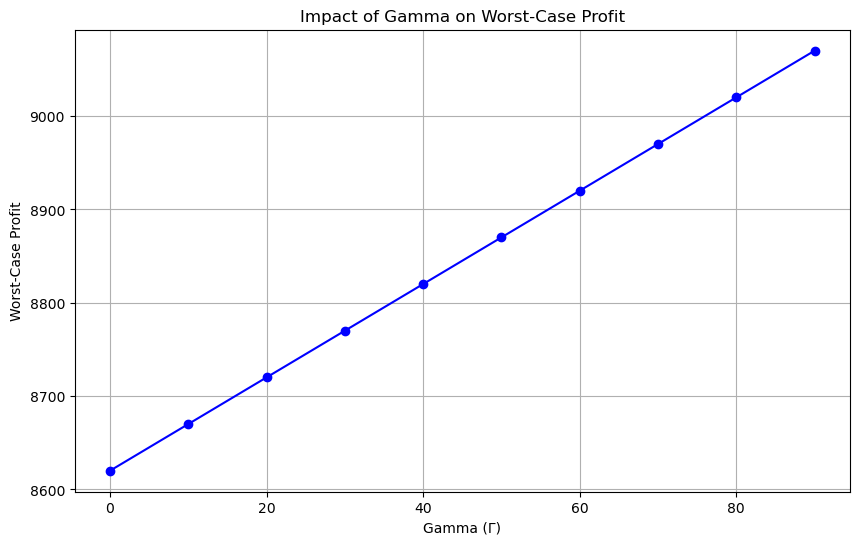

In [115]:
def find_a_solution_4(location, site_candidate, loc_site_pair, financial, gamma):
    m = gp.Model("Optimization_Model")
    sending_cost = financial.loc[0, 'sending_cost']
    revenue = financial.loc[0, 'revenue']
    site_building_cost = financial.loc[0, 'site_buiding_cost']

    # Variables
    sites = site_candidate['name'].tolist()
    locations = location['name'].tolist()
    x = m.addVars(sites, vtype=GRB.BINARY, name="x")
    y = m.addVars(locations, sites, vtype=GRB.CONTINUOUS, name="y")

    # Total demand variable
    D = m.addVar(vtype=GRB.CONTINUOUS, name="TotalDemand")

    # Constraints
    m.addConstr(D == gp.quicksum(y[i, j] for i in locations for j in sites))
    m.addConstr(D >= sum(location['lb']) - gamma, "MinDemand")
    m.addConstr(D <= sum(location['ub']) + gamma, "MaxDemand")

    for i in locations:
        for j in sites:
            m.addConstr(y[i, j] <= location.loc[location['name'] == i, 'ub'].iloc[0] * 
                        loc_site_pair.loc[(loc_site_pair['location_name'] == i) & (loc_site_pair['site_name'] == j), 'discounting_factor'].iloc[0] * x[j])

    # Objective
    m.setObjective(revenue * gp.quicksum(y[i, j] for i in locations for j in sites) -
                   sending_cost * gp.quicksum(y[i, j] for i in locations for j in sites) -
                   site_building_cost * gp.quicksum(x[j] for j in sites), GRB.MAXIMIZE)

    m.Params.LogToConsole = 0
    
    m.optimize()

    selected_sites = [j for j in sites if x[j].X > 0.5]
    optimal_profit = m.objVal if m.status == GRB.OPTIMAL else 0

    return selected_sites, optimal_profit

gammas = range(0, 100, 10)  # Vary Gamma from 0 to 90 in steps of 10
profits = []

for gamma in gammas:
    _, profit = find_a_solution_4(location, site_candidate, loc_site_pair, financial, gamma)
    profits.append(profit)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(gammas, profits, marker='o', linestyle='-', color='b')
plt.title('Impact of Gamma on Worst-Case Profit')
plt.xlabel('Gamma (Γ)')
plt.ylabel('Worst-Case Profit')
plt.grid(True)
plt.show()

#### Question 4: 
Convince your supervisor this new solution would "work" in different scenarios with limited demand information. You have to present evidence to support your solutions and convince your supervisor that your choice of sites will lead to the best outcome for mgscParcel if they implement it (under limited demand information regime).

Describe in words HOW you will setup this assessment task, why you choose those scenarios and the metric you're using
#### ####YOUR ANSWER GOES HERE

In [ ]:
# show how your policy performs under different scenarios


# YOUR CODE GOES HERE

#### Question 5: 
Suppose you were given empirical estimates of mean (and stdev) for demand for each location across multiple days is $\tilde{d}_i$ (and $\sigma_i$) and assume demand is stationary. Describe how you would build a confidence interval for **total demand for the survey period for each location**. Explain then how you would the previous framework (duality) to optimize the worst case performance of mgscParcel under this uncertainty set of demand. 
#### Hint: 
    Think of the central limit theorem for sum of iid random variables. 

In [ ]:
#### ####YOUR ANSWER AND MODEL GOES HERE

### NO NEED TO CODE THIS MODEL 